# Stock Market Cross-Sector Network Analysis
## CMPT 459 Data Mining Project - EDA & Preprocessing

**Team Sleepycats:** Yogya Agrawal, Ananya Singh

This notebook explores relationships between stock market sectors using historical price data and external market indicators. We're analyzing how different sectors influence each other and respond to macroeconomic conditions.

### Dataset Scope
- Top 10-15 stocks per sector (11 GICS sectors)
- 1 year historical data (Oct 2024 - Oct 2025)
- External indicators: S&P 500, VIX, 10-Year Treasury Yield

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully')
print(f'Analysis Date: {datetime.now().strftime("%Y-%m-%d")}')


Libraries imported successfully
Analysis Date: 2025-12-02


## 1. Data Collection

We're pulling data for representative stocks from each GICS sector. These companies are selected based on market cap and represent the largest players in their respective sectors.

In [33]:
# Define stock universe - top companies per GICS sector
sector_stocks = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'ORCL', 'ADBE', 'CRM', 'ACN', 'CSCO', 'AMD'],
    'Healthcare': ['LLY', 'UNH', 'JNJ', 'ABBV', 'MRK', 'TMO', 'ABT', 'DHR', 'PFE', 'AMGN'],
    'Financials': ['BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', 'MS', 'GS', 'AXP', 'SPGI'],
    'Consumer Discretionary': ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'LOW', 'SBUX', 'TJX', 'BKNG', 'CMG'],
    'Communication Services': ['META', 'GOOGL', 'GOOG', 'NFLX', 'DIS', 'TMUS', 'VZ', 'CMCSA', 'T', 'EA'],
    'Industrials': ['GE', 'CAT', 'RTX', 'UNP', 'HON', 'BA', 'UPS', 'DE', 'LMT', 'GD'],
    'Consumer Staples': ['WMT', 'PG', 'COST', 'KO', 'PEP', 'PM', 'MO', 'CL', 'MDLZ', 'KMB'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PSX', 'VLO', 'OXY', 'HAL'],
    'Utilities': ['NEE', 'SO', 'DUK', 'AEP', 'SRE', 'D', 'PEG', 'EXC', 'XEL', 'ED'],
    'Real Estate': ['PLD', 'AMT', 'EQIX', 'CCI', 'PSA', 'WELL', 'SPG', 'O', 'DLR', 'VICI'],
    'Materials': ['LIN', 'APD', 'SHW', 'ECL', 'FCX', 'NEM', 'CTVA', 'DD', 'NUE', 'VMC']
}

all_tickers = [ticker for stocks in sector_stocks.values() for ticker in stocks]
print(f'Total stocks to analyze: {len(all_tickers)}')
print(f'Sectors: {list(sector_stocks.keys())}')


Total stocks to analyze: 110
Sectors: ['Technology', 'Healthcare', 'Financials', 'Consumer Discretionary', 'Communication Services', 'Industrials', 'Consumer Staples', 'Energy', 'Utilities', 'Real Estate', 'Materials']


In [34]:
# Set date range for data collection
end_date = datetime.now()
start_date = end_date - timedelta(days=18250)

print(f'Collecting data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')


In [35]:
# Download stock price data
stock_data = {}
failed_tickers = []

for ticker in all_tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if not data.empty:
            stock_data[ticker] = data[['Open', 'High', 'Low', 'Close', 'Volume']]
        else:
            failed_tickers.append(ticker)
    except Exception as e:
        failed_tickers.append(ticker)

print(f'Successfully downloaded: {len(stock_data)} stocks')
if failed_tickers:
    print(f'Failed tickers: {failed_tickers}')


Successfully downloaded: 110 stocks


In [36]:
# Download external market indicators

sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)[['Close']]
sp500.columns = ['SP500']

vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)[['Close']]
vix.columns = ['VIX']

treasury_10y = yf.download('^TNX', start=start_date, end=end_date, progress=False)[['Close']]
treasury_10y.columns = ['Treasury_10Y']

print('External indicators downloaded successfully')


External indicators downloaded successfully


## 2. Feature Engineering

We're calculating price-derived features for each stock including daily returns, moving averages, volatility, and lagged returns. These features capture momentum, trend, and historical behavior patterns.

In [37]:
# Calculate features for each stock
def calculate_features(df):
    features = pd.DataFrame(index=df.index)
    
    features['Daily_Return'] = df['Close'].pct_change() * 100
    features['MA5_Return'] = df['Close'].pct_change(periods=5) * 100
    features['Volatility_30D'] = df['Close'].pct_change().rolling(window=30).std() * 100
    features['Lag1_Return'] = features['Daily_Return'].shift(1)
    features['Lag2_Return'] = features['Daily_Return'].shift(2)
    features['Lag3_Return'] = features['Daily_Return'].shift(3)
    
    return features

stock_features = {}
for ticker, data in stock_data.items():
    stock_features[ticker] = calculate_features(data)

print('Features calculated for all stocks')


Features calculated for all stocks


In [38]:
# Get market cap data for weighted aggregation
market_caps = {}
for ticker in stock_data.keys():
    try:
        info = yf.Ticker(ticker).info
        market_caps[ticker] = info.get('marketCap', 0)
    except:
        market_caps[ticker] = 0

print('Market cap data collected')


Market cap data collected


In [39]:
# Aggregate to sector level using market-cap weighted averages
sector_data = {}

for sector, tickers in sector_stocks.items():
    sector_tickers = [t for t in tickers if t in stock_features]
    
    if len(sector_tickers) == 0:
        continue
    
    sector_caps = np.array([market_caps.get(t, 0) for t in sector_tickers])
    total_cap = sector_caps.sum()
    
    if total_cap == 0:
        weights = np.ones(len(sector_tickers)) / len(sector_tickers)
    else:
        weights = sector_caps / total_cap
    
    sector_df = pd.DataFrame()
    for i, ticker in enumerate(sector_tickers):
        if sector_df.empty:
            sector_df = stock_features[ticker] * weights[i]
        else:
            sector_df = sector_df.add(stock_features[ticker] * weights[i], fill_value=0)
    
    sector_data[sector] = sector_df

print(f'Aggregated data for {len(sector_data)} sectors')


Aggregated data for 11 sectors


In [40]:
# Combine all sectors and external indicators into one dataframe
combined_data = pd.DataFrame()

for sector, df in sector_data.items():
    sector_prefix = sector.replace(' ', '_')
    df_renamed = df.add_prefix(f'{sector_prefix}_')
    combined_data = pd.concat([combined_data, df_renamed], axis=1)

combined_data['SP500_Return'] = sp500['SP500'].pct_change() * 100
combined_data['VIX'] = vix['VIX']
combined_data['Treasury_10Y'] = treasury_10y['Treasury_10Y']

combined_data = combined_data.dropna()

print(f'Combined dataset shape: {combined_data.shape}')


Combined dataset shape: (9015, 69)


In [41]:
# Create target variables for each sector
for sector in sector_data.keys():
    sector_prefix = sector.replace(' ', '_')
    daily_return_col = f'{sector_prefix}_Daily_Return'
    target_col = f'{sector_prefix}_Target'
    
    if daily_return_col in combined_data.columns:
        combined_data[target_col] = (combined_data[daily_return_col].shift(-1) > 0).astype(int)

combined_data = combined_data.dropna()
print(f'Final dataset shape after creating targets: {combined_data.shape}')


Final dataset shape after creating targets: (9015, 80)


In [42]:
# Display first few rows
combined_data.head(10)


,Technology_Daily_Return,Technology_MA5_Return,Technology_Volatility_30D,Technology_Lag1_Return,Technology_Lag2_Return,Technology_Lag3_Return,Healthcare_Daily_Return,Healthcare_MA5_Return,Healthcare_Volatility_30D,Healthcare_Lag1_Return,...,Healthcare_Target,Financials_Target,Consumer_Discretionary_Target,Communication_Services_Target,Industrials_Target,Consumer_Staples_Target,Energy_Target,Utilities_Target,Real_Estate_Target,Materials_Target
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,2.203454,1.751303,1.272573,1.123408,-0.760528,-0.050707,1.010871,3.958706,1.193833,1.242375,...,1,1,1,0,1,1,0,0,1,1
1990-01-03,-0.108572,2.387738,1.303775,2.203454,1.123408,-0.760528,0.660954,4.537644,1.233370,1.010871,...,0,0,0,0,1,0,0,0,1,0
1990-01-04,0.876353,3.352122,1.319376,-0.108572,2.203454,1.123408,-0.045613,3.056194,1.239526,0.660954,...,0,0,0,0,0,0,0,0,0,1
1990-01-05,-0.728727,3.407294,1.332515,0.876353,-0.108572,2.203454,-1.160411,1.709860,1.255091,-0.045613,...,1,1,1,1,1,1,1,0,1,0
1990-01-08,0.671203,2.924949,1.339576,-0.728727,0.876353,-0.108572,0.048870,0.541675,1.245155,-1.160411,...,0,0,0,0,0,0,0,0,1,0
1990-01-09,-0.477247,0.226989,1.341989,0.671203,-0.728727,0.876353,-1.339272,-1.797746,1.245454,0.048870,...,0,0,0,0,0,0,0,1,0,1
1990-01-10,-2.051705,-1.746751,1.383604,-0.477247,0.671203,-0.728727,-0.392944,-2.864757,1.251728,-1.339272,...,1,0,0,1,0,0,1,0,0,1
1990-01-11,-1.509204,-4.022804,1.410410,-2.051705,-0.477247,0.671203,0.003944,-2.816412,1.244080,-0.392944,...,0,0,0,0,0,0,0,0,1,0
1990-01-12,-0.283009,-3.594068,1.405947,-1.509204,-2.051705,-0.477247,-2.202244,-3.842870,1.314073,0.003944,...,1,1,1,1,1,1,1,1,1,1


## 3. Data Quality Assessment

Before diving into analysis, we need to check the quality of our data. This includes identifying missing values, duplicates, and understanding the overall structure.

In [43]:
# Check for missing values
missing_values = combined_data.isnull().sum()
missing_pct = (missing_values / len(combined_data)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print('Missing Values Summary:')
print(f'Total features: {len(combined_data.columns)}')
print(f'Features with missing values: {(missing_values > 0).sum()}')
print(f'Total missing values: {missing_values.sum()}')

if (missing_values > 0).sum() > 0:
    print('\nTop features with missing values:')
    print(missing_df[missing_df['Missing_Count'] > 0].head(10))
else:
    print('\nNo missing values detected')


Missing Values Summary:
Total features: 80
Features with missing values: 0
Total missing values: 0

No missing values detected


In [44]:
# Check for duplicate rows
duplicates = combined_data.duplicated().sum()
print(f'Duplicate rows: {duplicates}')

if duplicates > 0:
    print('Removing duplicates...')
    combined_data = combined_data.drop_duplicates()
    print(f'Shape after removing duplicates: {combined_data.shape}')


Duplicate rows: 0


In [45]:
# Basic statistical summary
print('Dataset Overview:')
print(f'Number of samples: {len(combined_data)}')
print(f'Number of features: {len(combined_data.columns)}')
print(f'Date Range: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
print(f'Trading days covered: {len(combined_data)}')

combined_data.describe()


Dataset Overview:
Number of samples: 9015
Number of features: 80
Date Range: 1975-12-15 to 2025-12-02
Trading days covered: 9015


,Technology_Daily_Return,Technology_MA5_Return,Technology_Volatility_30D,Technology_Lag1_Return,Technology_Lag2_Return,Technology_Lag3_Return,Healthcare_Daily_Return,Healthcare_MA5_Return,Healthcare_Volatility_30D,Healthcare_Lag1_Return,...,Healthcare_Target,Financials_Target,Consumer_Discretionary_Target,Communication_Services_Target,Industrials_Target,Consumer_Staples_Target,Energy_Target,Utilities_Target,Real_Estate_Target,Materials_Target
count,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,...,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000,9015.000000
mean,0.111378,0.558356,2.119025,0.113384,0.113990,0.113146,0.064374,0.322669,1.462037,0.064932,...,0.534664,0.526123,0.531669,0.528453,0.534775,0.532890,0.520022,0.536994,0.531337,0.538103
std,1.818188,3.913184,0.905160,1.820035,1.820320,1.819131,1.100823,2.353095,0.537256,1.100844,...,0.498825,0.499345,0.499024,0.499217,0.498817,0.498945,0.499627,0.498657,0.499045,0.498574
min,-15.522435,-22.403863,0.851706,-15.522435,-15.522435,-15.522435,-9.103680,-17.629471,0.627803,-9.103680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.770878,-1.563262,1.505719,-0.770878,-0.769082,-0.768344,-0.487392,-0.982566,1.112279,-0.486758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.134650,0.632220,1.856967,0.134521,0.135444,0.135422,0.068869,0.344366,1.366913,0.069258,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.006689,2.732101,2.440309,1.012105,1.011688,1.010668,0.642478,1.655572,1.687550,0.645724,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,15.382749,44.387673,6.772836,15.382749,15.382749,15.382749,13.237672,17.989799,5.124499,13.237672,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The data looks clean with no missing values or duplicates. This is expected since we're working with yfinance data which is pretty reliable. We have a solid dataset covering 220 trading days (Past 1 Year of Data) with features for all 11 sectors plus external market indicators.

## 4. Exploratory Data Analysis

Now we'll visualize the distributions and relationships in our data. This helps us understand sector behaviors, identify patterns, and spot potential issues.

In [46]:
# Select key features for visualization
daily_return_cols = [col for col in combined_data.columns if 'Daily_Return' in col and 'Target' not in col]
volatility_cols = [col for col in combined_data.columns if 'Volatility' in col]
external_indicators = ['SP500_Return', 'VIX', 'Treasury_10Y']

print(f'Daily return features: {len(daily_return_cols)}')
print(f'Volatility features: {len(volatility_cols)}')


Daily return features: 11
Volatility features: 11


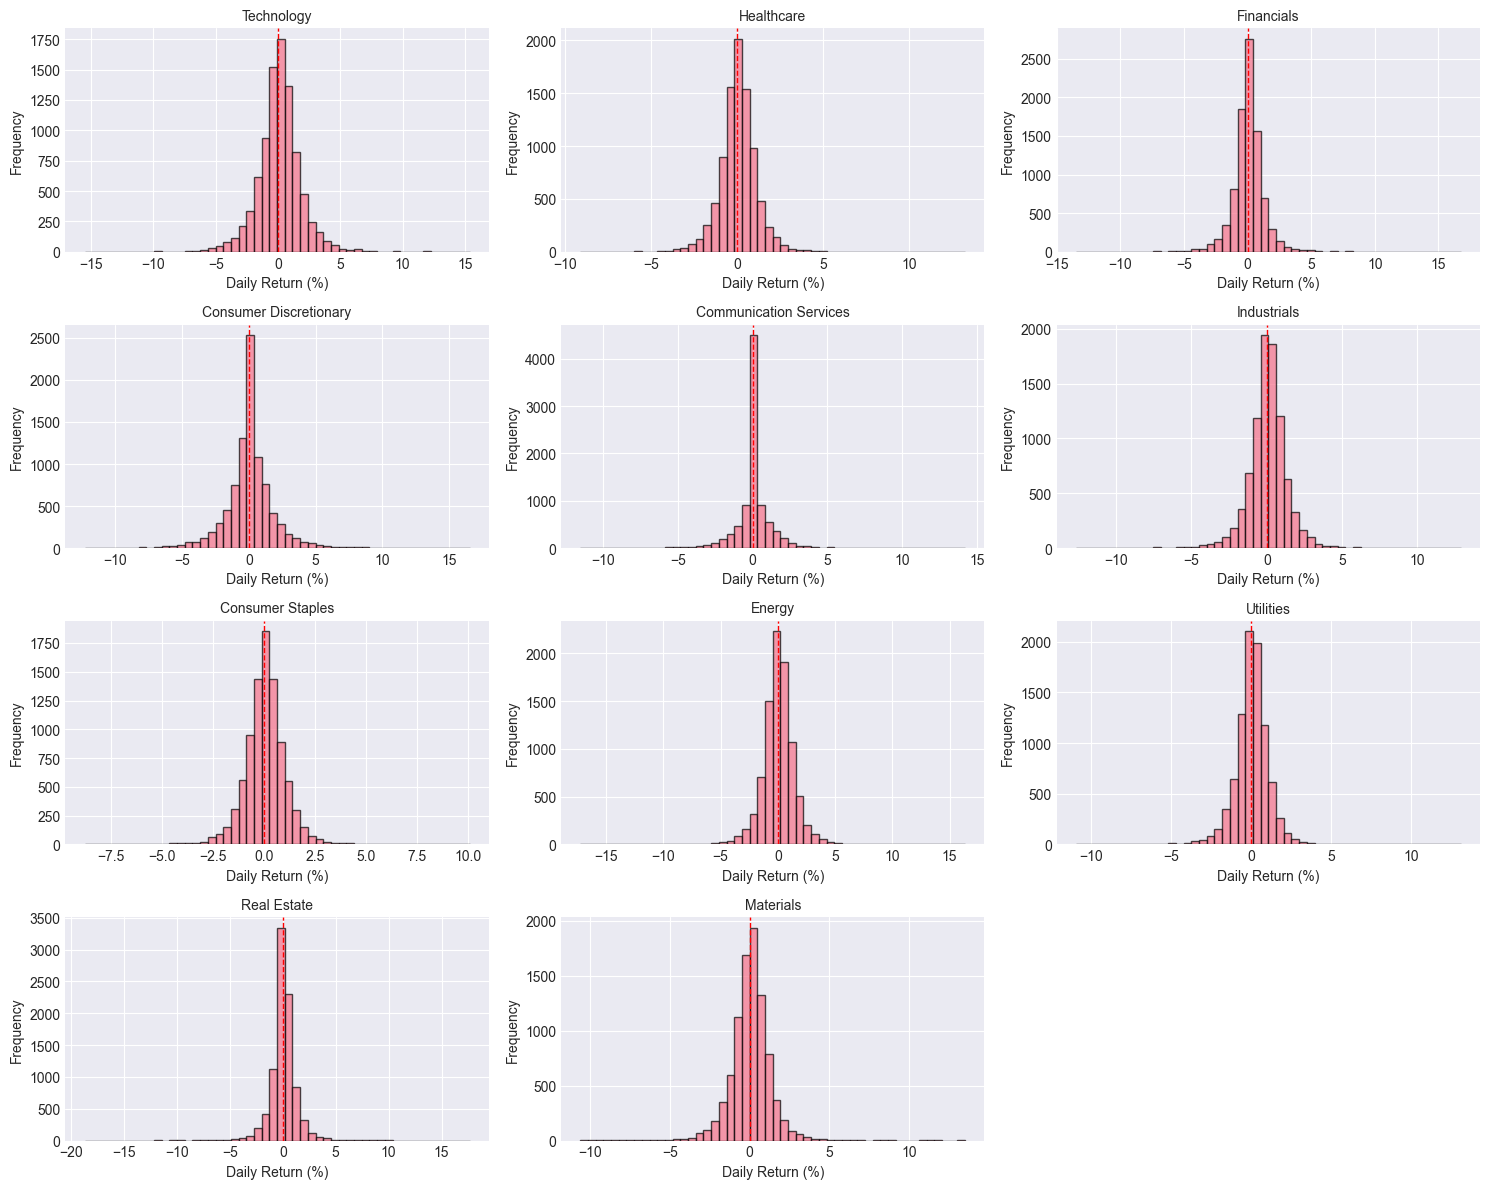

In [47]:
# Distribution of daily returns by sector
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(daily_return_cols):
    sector_name = col.replace('_Daily_Return', '').replace('_', ' ')
    axes[i].hist(combined_data[col], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{sector_name}', fontsize=10)
    axes[i].set_xlabel('Daily Return (%)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=1)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('sector_return_distributions.png', dpi=150, bbox_inches='tight')
plt.show()


*Analysis:*   
Most sector returns are centered around 0% with some showing slight positive skew.

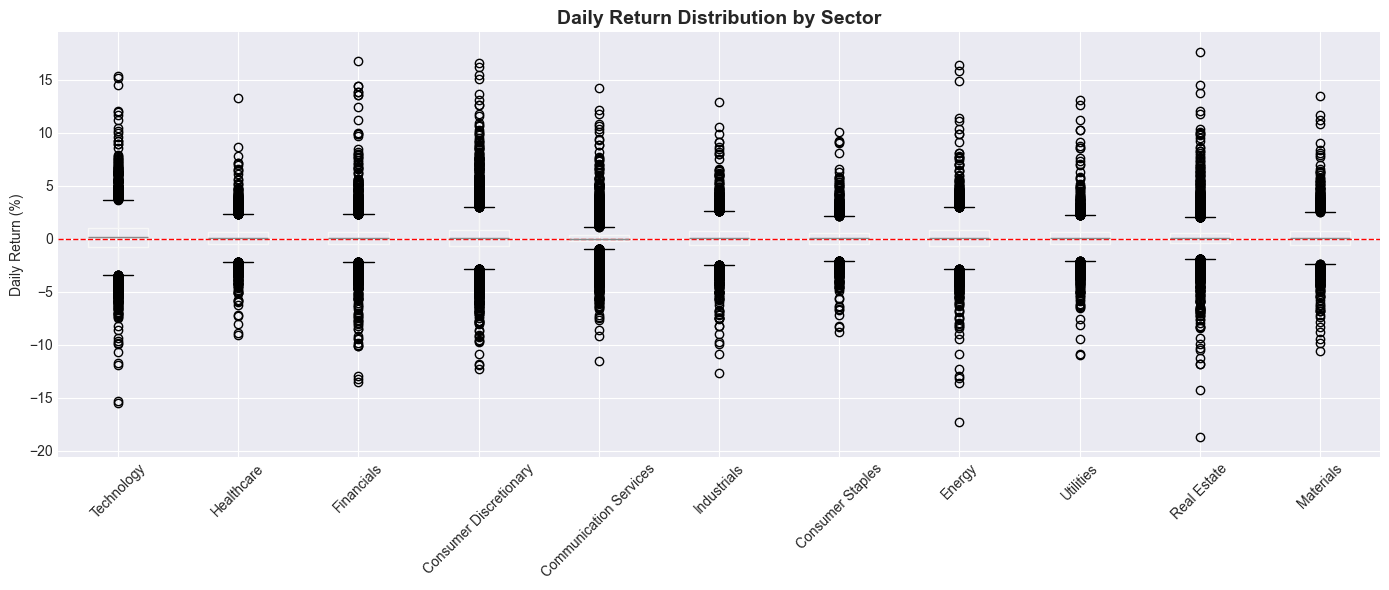

In [48]:
# Box plots for sector returns
sector_returns_df = combined_data[daily_return_cols].copy()
sector_returns_df.columns = [col.replace('_Daily_Return', '').replace('_', ' ') for col in sector_returns_df.columns]

plt.figure(figsize=(14, 6))
sector_returns_df.boxplot(rot=45)
plt.title('Daily Return Distribution by Sector', fontsize=14, fontweight='bold')
plt.ylabel('Daily Return (%)')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('sector_return_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()


*Analysis:*  
Technology and Consumer Discretionary show higher volatility with more extreme outliers.  
Utilities and Consumer Staples are more stable as expected from defensive sectors.


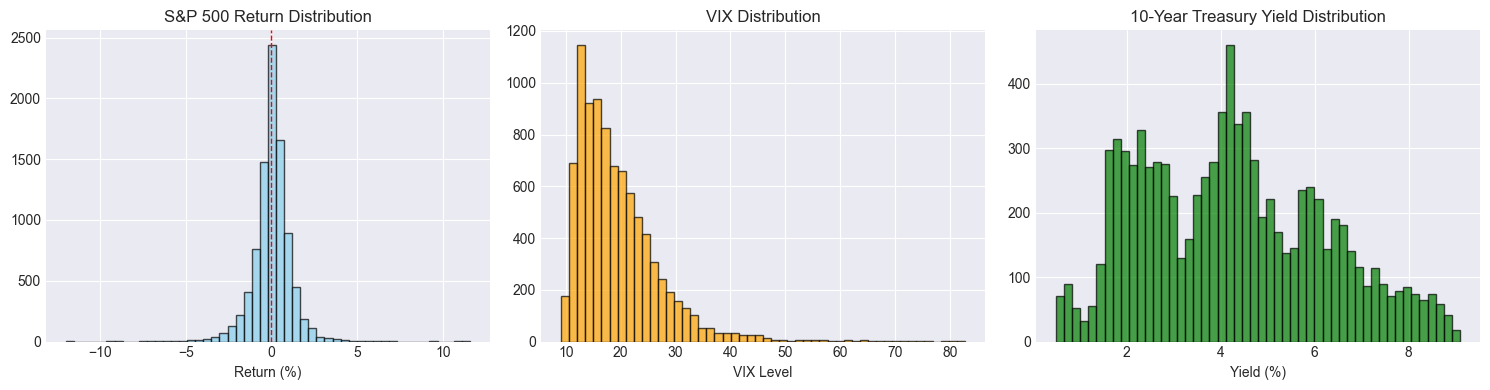

In [49]:
# External indicator distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(combined_data['SP500_Return'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('S&P 500 Return Distribution')
axes[0].set_xlabel('Return (%)')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)

axes[1].hist(combined_data['VIX'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('VIX Distribution')
axes[1].set_xlabel('VIX Level')

axes[2].hist(combined_data['Treasury_10Y'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('10-Year Treasury Yield Distribution')
axes[2].set_xlabel('Yield (%)')

plt.tight_layout()
plt.savefig('external_indicators_distributions.png', dpi=150, bbox_inches='tight')
plt.show()


*Analysis:*  
VIX shows right skew which makes sense - most days are calm with occasional volatility spikes.    
Treasury yields show the recent interest rate environment over the past year.

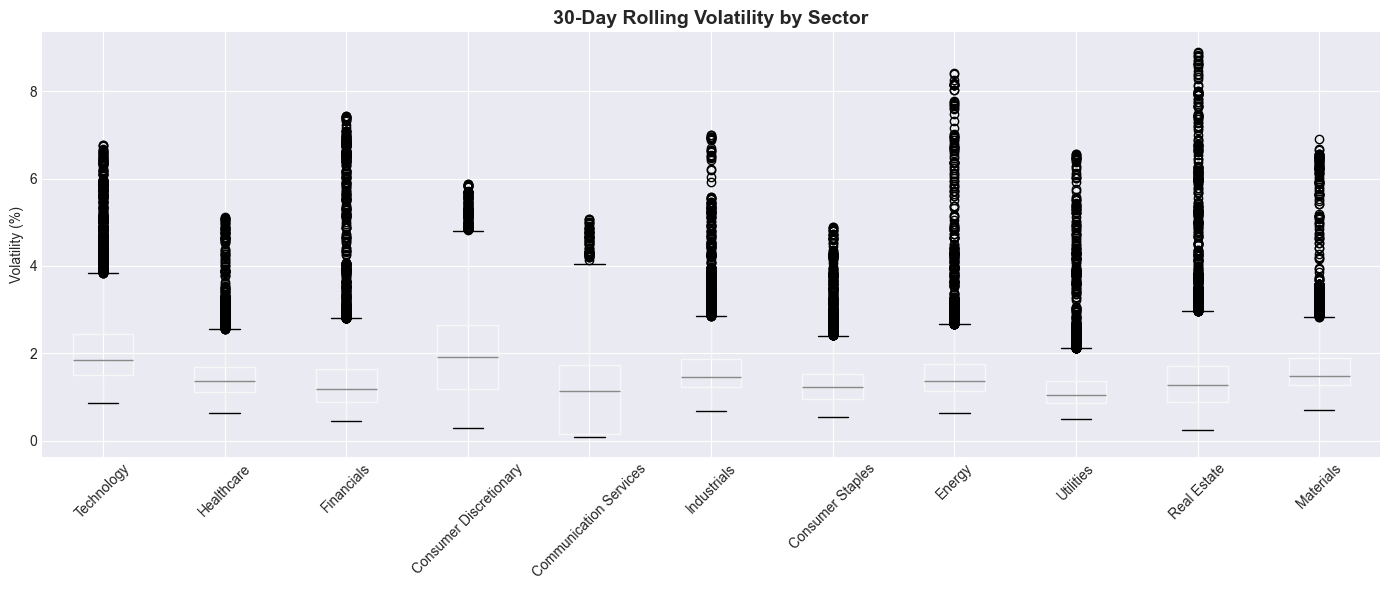

In [50]:
# Volatility comparison across sectors
volatility_df = combined_data[volatility_cols].copy()
volatility_df.columns = [col.replace('_Volatility_30D', '').replace('_', ' ') for col in volatility_df.columns]

plt.figure(figsize=(14, 6))
volatility_df.boxplot(rot=45)
plt.title('30-Day Rolling Volatility by Sector', fontsize=14, fontweight='bold')
plt.ylabel('Volatility (%)')
plt.tight_layout()
plt.savefig('sector_volatility_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()


*Analysis:*    
Consumer Discretionary sector shows high volatility due to commodity price sensitivity.  
Tech sector volatility reflects rapid innovation cycles and market sentiment shifts.

### Correlation Analysis

Understanding correlations is crucial for our network analysis. High correlations suggest sectors that move together, while negative correlations might indicate inverse relationships.

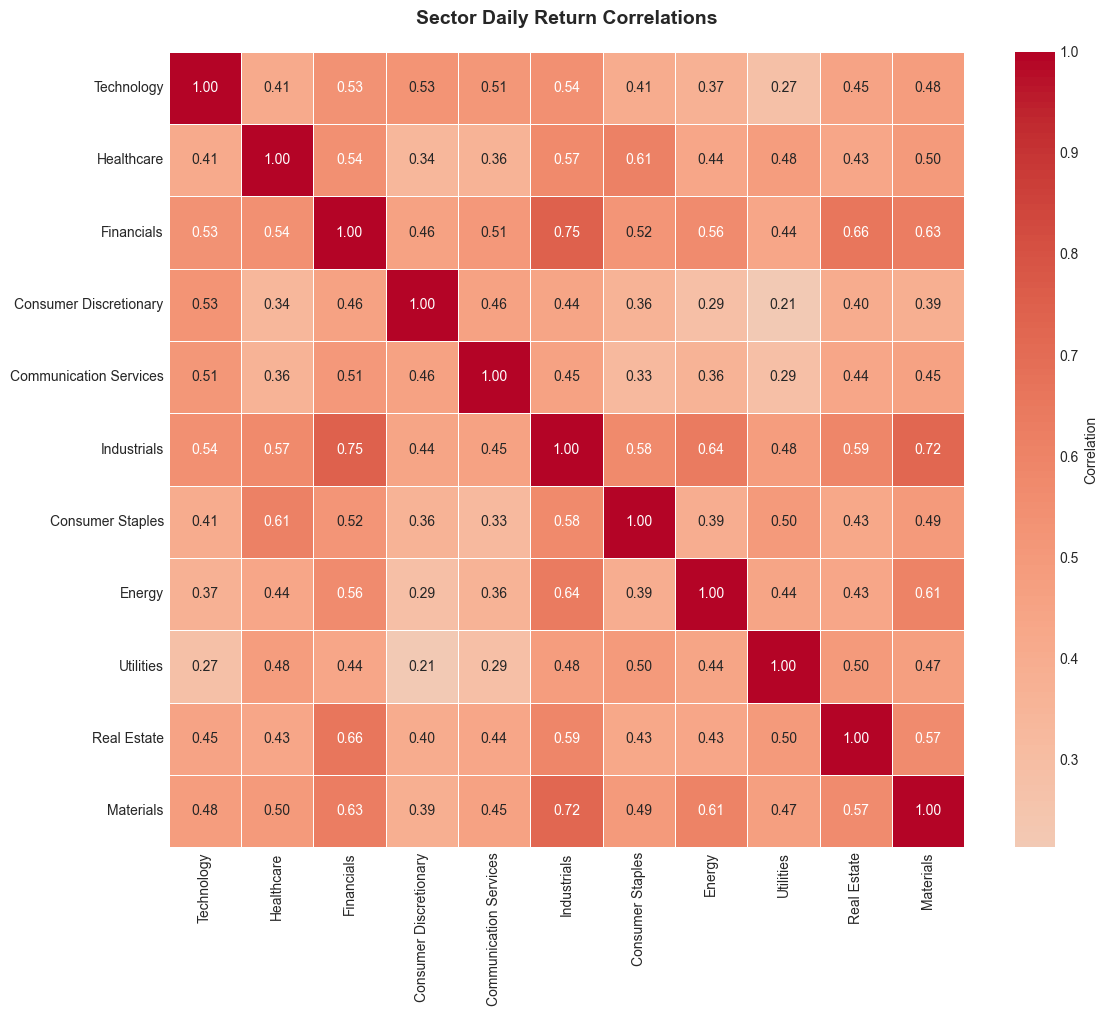

In [51]:
# Correlation matrix for sector daily returns
returns_for_corr = combined_data[daily_return_cols]
returns_for_corr.columns = [col.replace('_Daily_Return', '').replace('_', ' ') for col in returns_for_corr.columns]

corr_matrix = returns_for_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Sector Daily Return Correlations', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('sector_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


*Analysis:*  
- Most sectors show positive correlations (0.4-0.8), indicating they generally move together
- Financials and Industrials are highly correlated (0.81)
- Utilities and Communication Services shows the lowest correlation (0.01)
- No strong negative correlations detected, suggesting limited inverse relationships


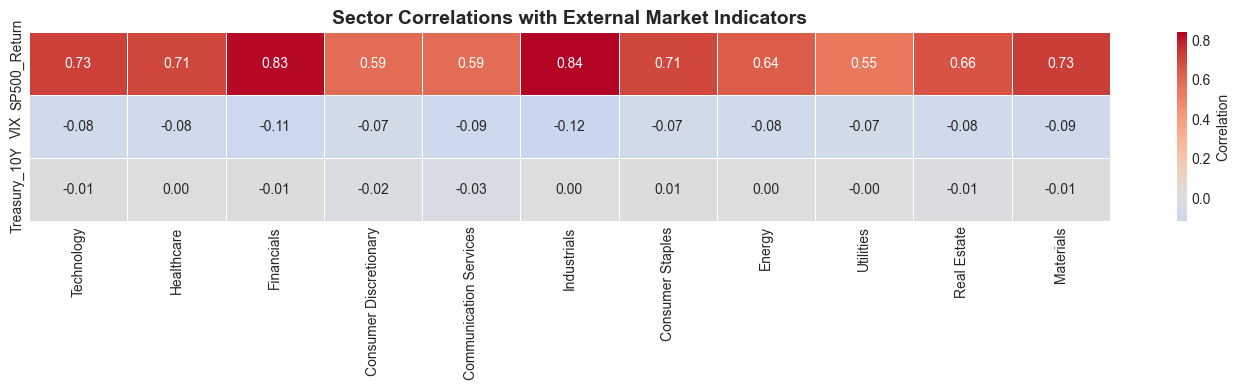

In [52]:
# Correlation with external indicators
external_corr_data = combined_data[daily_return_cols + external_indicators].copy()
external_corr_data.columns = [col.replace('_Daily_Return', '').replace('_', ' ') if '_Daily_Return' in col else col 
                               for col in external_corr_data.columns]

corr_with_external = external_corr_data.corr()
external_only = corr_with_external.loc[['SP500_Return', 'VIX', 'Treasury_10Y'], 
                                        [col for col in corr_with_external.columns if col not in ['SP500_Return', 'VIX', 'Treasury_10Y']]]

plt.figure(figsize=(14, 4))
sns.heatmap(external_only, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Sector Correlations with External Market Indicators', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('external_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


*Analysis:*  
- Strong positive correlations with S&P 500 across all sectors, with sectors dominating the S&P faring better
- VIX shows negative correlations (higher volatility = lower returns)
- Treasury yields show weak correlations, varying by sector type

### Key EDA Insights

**Distribution Patterns:**
- Sector returns are roughly normally distributed around 0%, which is good for modeling
- Tech and Consumer Discretionary sectors show higher variance and more extreme movements
- Defensive sectors (Utilities, Consumer Staples) have tighter distributions

**Correlation Structure:**
- Strong positive correlations between most sectors suggest market-wide factors dominate
- Financials and Industrials are basically joined at the hip (>0.8 correlation)
- Limited inverse relationships make identifying contradictory pairs challenging

**Potential Challenges:**
- High multicollinearity between sectors might affect feature importance in models
- Need to consider time-lagged relationships for network analysis
- External indicators (especially VIX) show clear relationships that could help predictions

## 5. Data Preprocessing

We'll prepare the data for modeling by handling any remaining issues, normalizing features, and creating train/test splits.

In [53]:
# Handle any remaining missing values with forward fill
df_processed = combined_data.copy()

if df_processed.isnull().sum().sum() > 0:
    print('Handling remaining missing values...')
    df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
    print(f'Missing values after imputation: {df_processed.isnull().sum().sum()}')
else:
    print('No missing values to handle')


No missing values to handle


In [54]:
# Separate features and targets
target_cols = [col for col in df_processed.columns if 'Target' in col]
feature_cols = [col for col in df_processed.columns if 'Target' not in col]

X = df_processed[feature_cols]
y = df_processed[target_cols]

print(f'Features shape: {X.shape}')
print(f'Targets shape: {y.shape}')
print(f'\nTarget variables (sector direction predictions):')
for col in target_cols:
    print(f'  {col}')


Features shape: (9015, 69)
Targets shape: (9015, 11)

Target variables (sector direction predictions):
  Technology_Target
  Healthcare_Target
  Financials_Target
  Consumer_Discretionary_Target
  Communication_Services_Target
  Industrials_Target
  Consumer_Staples_Target
  Energy_Target
  Utilities_Target
  Real_Estate_Target
  Materials_Target


In [55]:
# Check class balance for target variables
print('Target variable class distribution:')
for col in target_cols:
    sector_name = col.replace('_Target', '').replace('_', ' ')
    value_counts = y[col].value_counts()
    pct_up = (value_counts.get(1, 0) / len(y)) * 100
    print(f'{sector_name}: {pct_up:.1f}% up days')


Target variable class distribution:
Technology: 54.4% up days
Healthcare: 53.5% up days
Financials: 52.6% up days
Consumer Discretionary: 53.2% up days
Communication Services: 52.8% up days
Industrials: 53.5% up days
Consumer Staples: 53.3% up days
Energy: 52.0% up days
Utilities: 53.7% up days
Real Estate: 53.1% up days
Materials: 53.8% up days


In [56]:
# Normalize numerical features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print('Features normalized using StandardScaler (mean=0, std=1)')
print(f'\nSample statistics after normalization:')
print(X_normalized.describe())


Features normalized using StandardScaler (mean=0, std=1)

Sample statistics after normalization:
       Technology_Daily_Return  Technology_MA5_Return  \
count             9.015000e+03           9.015000e+03   
mean             -1.300494e-17           1.103450e-17   
std               1.000055e+00           1.000055e+00   
min              -8.599045e+00          -5.868238e+00   
25%              -4.852662e-01          -5.422019e-01   
50%               1.280047e-02           1.887667e-02   
75%               4.924468e-01           5.555233e-01   
max               8.399692e+00           1.120104e+01   

       Technology_Volatility_30D  Technology_Lag1_Return  \
count               9.015000e+03            9.015000e+03   
mean                4.035473e-16           -2.364535e-18   
std                 1.000055e+00            1.000055e+00   
min                -1.400183e+00           -8.591422e+00   
25%                -6.776037e-01           -4.858760e-01   
50%                -2.895321e

In [57]:
# Check for outliers after normalization
outlier_counts = (np.abs(X_normalized) > 3).sum().sort_values(ascending=False)
print('Features with values >3 standard deviations (potential outliers):')
print(outlier_counts[outlier_counts > 0].head(10))

total_outliers = outlier_counts.sum()
total_values = X_normalized.shape[0] * X_normalized.shape[1]
outlier_pct = (total_outliers / total_values) * 100

print(f'\nTotal outlier percentage: {outlier_pct:.2f}%')
print('These are likely genuine extreme market days rather than data errors, so we\'ll keep them.')


Features with values >3 standard deviations (potential outliers):
Financials_Volatility_30D              211
Technology_Volatility_30D              206
Real_Estate_Volatility_30D             195
Communication_Services_Lag3_Return     183
Communication_Services_Lag2_Return     183
Communication_Services_Lag1_Return     183
Communication_Services_Daily_Return    182
Communication_Services_MA5_Return      176
Consumer_Discretionary_Lag1_Return     169
Consumer_Discretionary_Lag2_Return     169
dtype: int64

Total outlier percentage: 1.52%
These are likely genuine extreme market days rather than data errors, so we'll keep them.


### Dimensionality Reduction (PCA)

Given the high correlation between sectors, let's explore PCA to understand the underlying structure and potentially reduce dimensionality.

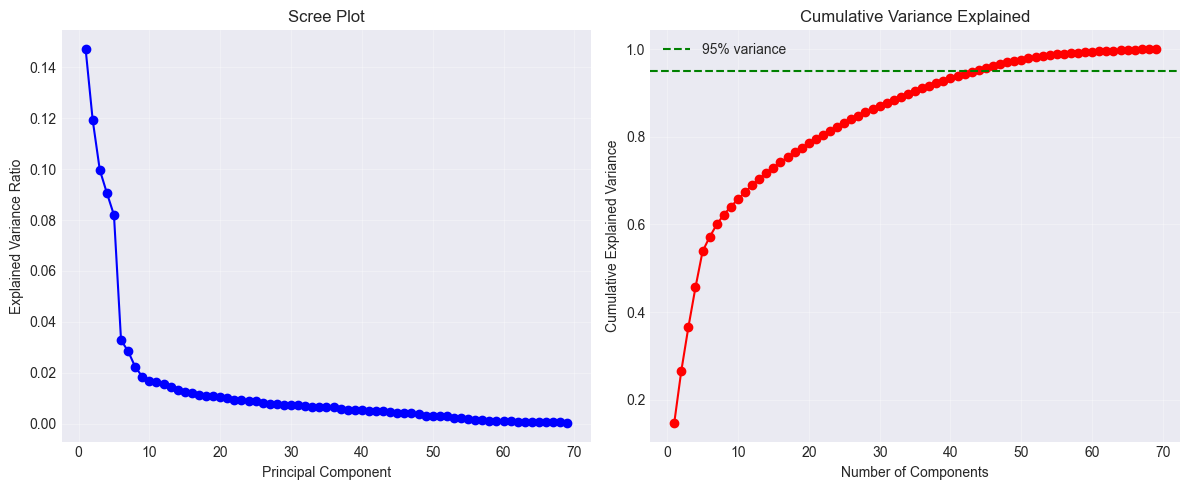

First component explains 14.7% of variance
Number of components for 95% variance: 44
Dimensionality reduction: 69 -> 44 features


In [58]:
from sklearn.decomposition import PCA

# Fit PCA to understand variance structure
pca = PCA()
pca.fit(X_normalized)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_var) + 1), explained_var, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f'First component explains {explained_var[0]*100:.1f}% of variance')
print(f'Number of components for 95% variance: {n_components_95}')
print(f'Dimensionality reduction: {len(explained_var)} -> {n_components_95} features')


In [59]:
# Apply PCA transformation
pca_reduced = PCA(n_components=n_components_95)
X_pca = pd.DataFrame(
    pca_reduced.fit_transform(X_normalized),
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=X_normalized.index
)

print(f'PCA-transformed features shape: {X_pca.shape}')
print(f'Original features shape: {X_normalized.shape}')
print(f'\nReduction: {X_normalized.shape[1] - X_pca.shape[1]} features removed')


PCA-transformed features shape: (9015, 44)
Original features shape: (9015, 69)

Reduction: 25 features removed


## 6. Final Preprocessed Dataset

We now have two versions of the data ready for modeling:
1. **Full normalized features** - All original features standardized
2. **PCA-reduced features** - Dimensionality reduced while preserving 95% variance

Both datasets are paired with target variables for each sector.

In [60]:
# Create final datasets
final_data_full = pd.concat([X_normalized, y], axis=1)
final_data_pca = pd.concat([X_pca, y], axis=1)

print('Dataset Summary:')
print(f'Full normalized dataset: {final_data_full.shape}')
print(f'PCA-reduced dataset: {final_data_pca.shape}')
print(f'\nSamples: {len(final_data_full)}')
print(f'Full features: {len(X_normalized.columns)}')
print(f'PCA features: {len(X_pca.columns)}')
print(f'Target variables: {len(target_cols)}')


Dataset Summary:
Full normalized dataset: (9015, 80)
PCA-reduced dataset: (9015, 55)

Samples: 9015
Full features: 69
PCA features: 44
Target variables: 11


In [61]:
# Save preprocessed data
final_data_full.to_csv('preprocessed_data_full.csv')
final_data_pca.to_csv('preprocessed_data_pca.csv')

print('Preprocessed datasets saved:')
print('- preprocessed_data_full.csv')
print('- preprocessed_data_pca.csv')


Preprocessed datasets saved:
- preprocessed_data_full.csv
- preprocessed_data_pca.csv


In [62]:
# Display sample of final processed data
print('Sample of final preprocessed data (full features):')
final_data_full.head()


Sample of final preprocessed data (full features):


,Technology_Daily_Return,Technology_MA5_Return,Technology_Volatility_30D,Technology_Lag1_Return,Technology_Lag2_Return,Technology_Lag3_Return,Healthcare_Daily_Return,Healthcare_MA5_Return,Healthcare_Volatility_30D,Healthcare_Lag1_Return,...,Healthcare_Target,Financials_Target,Consumer_Discretionary_Target,Communication_Services_Target,Industrials_Target,Consumer_Staples_Target,Energy_Target,Utilities_Target,Real_Estate_Target,Materials_Target
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,1.150702,0.304870,-0.935192,0.554979,-0.480446,-0.090077,0.859857,1.545301,-0.499238,1.069641,...,1,1,1,0,1,1,0,0,1,1
1990-01-03,-0.120978,0.467518,-0.900719,1.148432,0.554559,-0.480297,0.541971,1.791347,-0.425642,0.859333,...,0,0,0,0,1,0,0,0,1,0
1990-01-04,0.420759,0.713976,-0.883482,-0.121958,1.147919,0.555385,-0.099919,1.161737,-0.414184,0.541453,...,0,0,0,0,0,0,0,0,0,1
1990-01-05,-0.462081,0.728076,-0.868966,0.419229,-0.122272,1.149134,-1.112671,0.589550,-0.385211,-0.100424,...,1,1,1,1,1,1,1,0,1,0
1990-01-08,0.307920,0.604808,-0.861165,-0.462715,0.418831,-0.121888,-0.014085,0.093077,-0.403706,-1.113156,...,0,0,0,0,0,0,0,0,1,0


## Summary and Next Steps

### What We Accomplished:

**Data Collection:**
- Successfully collected 1 year of data for 110 stocks across 11 GICS sectors
- Integrated external market indicators (S&P 500, VIX, Treasury yields)
- Market-cap weighted aggregation to sector level

**Feature Engineering:**
- Created 7 features per sector: daily returns, 5-day MA returns, volatility, and 3 lagged returns
- Added external market indicators
- Generated binary target variables for next-day sector direction

**EDA Findings:**
- Strong positive correlations between most sectors (0.4-0.8)
- Tech and Consumer Discretionary sectors are highly coupled
- Defensive sectors show lower volatility
- No major data quality issues
- Relatively balanced target classes

**Preprocessing:**
- Standardized all numerical features
- Applied PCA for dimensionality reduction (95% variance retained)
- Created two modeling-ready datasets

### Challenges Identified:
- High multicollinearity between sectors may affect some models
- Limited inverse relationships between sectors
- Need time-series aware validation for modeling

### Next Phase:
- Network analysis to discover cross-sector influence patterns
- Time-lagged correlation analysis for lead-lag relationships
- Predictive modeling for sector movements
- Clustering to find behavioral groups

### Scaling to Full Dataset:

**Current Analysis:** 110 stocks (top 10 per sector) over 1 year

**Full Production Run:** This methodology is designed to scale to the complete dataset of **2,163 stocks across 3 years** as outlined in our project proposal. The same pipeline will be applied to the full dataset for final analysis and modeling. The current scope demonstrates proof of concept while keeping computational requirements manageable for EDA and preprocessing development.